## [**Dirichlet Process Mixture Models in Pyro**](http://pyro.ai/examples/dirichlet_process_mixture.html#Dirichlet-Process-Mixture-Models-in-Pyro)

#####  The prototypical example of Bayesian nonparametrics in practice is the Dirichlet Process Mixture Model (DPMM). A DPMM allows for a practitioner to build a mixture model when the number of distinct clusters in the geometric structure of their data is unknown – in other words, the number of clusters is allowed to grow as more data is observed. This feature makes the DPMM highly useful towards exploratory data analysis, where few facets of the data in question are known; this presentation aims to demonstrate this fact.

$$(G(\Omega_1), ..., G(\Omega_k)) \sim \text{Dir}(\alpha G_0(\Omega_1), ..., \alpha G_0(\Omega_k))$$

Imagine a restaurant with infinite tables (indexed by the positive integers) that accepts customers one at a time. The n th customer chooses their seat according to the following probabilities:

## [The Stick-Breaking Method (Sethuraman, 1994)](http://pyro.ai/examples/dirichlet_process_mixture.html#The-Stick-Breaking-Method-(Sethuraman,-1994))

1. $\beta_i \sim \text{Beta}(1, \alpha)$ for $i \in \mathbb{N}$
2. $\theta_i \sim G_0$ for $i \in \mathbb{N}$
3. $\pi_i(\beta_{1:\infty}) = \beta_i \prod_{j<i} (1-\beta_j)$
4. $z_n \sim \pi(\beta_{1:\infty})$ and then $x_n \sim f(\theta_{z_n})$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.distributions import constraints

import pyro
from pyro.distributions import *
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.optim import Adam

assert pyro.__version__.startswith('1.8.3')
pyro.set_rng_seed(0)

In [2]:
data = torch.cat(
    (
        MultivariateNormal(-8* torch.ones(2), torch.eye(2)).sample([50]),
        MultivariateNormal(8* torch.ones(2), torch.eye(2)).sample([50]),
        MultivariateNormal(torch.tensor([1.5,2]), torch.eye(2)).sample([50]),
        MultivariateNormal(torch.tensor([-0.5,1]), torch.eye(2)).sample([50])
    )
)

In [3]:
N = data.size()[0]

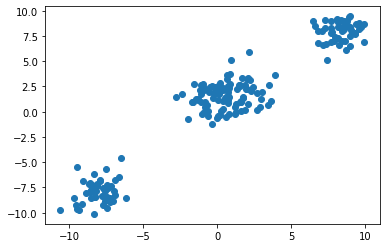

In [4]:
plt.scatter(data[:, 0], data[:, 1])

### In this example, the cluster parameters $\theta_i$ are two dimensional vectors describing the means of a multivariate Gaussian with identity covariance. Therefore, the Dirichlet process base distribution  is also a multivariate Gaussian (i.e. the conjugate prior)

In [5]:
def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    #print(beta1m_cumprod)
    #print(F.pad(beta, (0,1), value=1))
    #print(F.pad(beta1m_cumprod, (1,0), value=1))
    return F.pad(beta, (0,1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

In [6]:
mix_weights(torch.tensor([2,2,3,4]))

tensor([ 2, -2,  3, -8,  6])

In [7]:
def model(data):
    with pyro.plate("beta_plate", T-1):
        beta = pyro.sample('beta', Beta(1, alpha))
    with pyro.plate('mu_plate', T):
        mu = pyro.sample('mu', MultivariateNormal(torch.zeros(2), 5 * torch.eye(2)))

    with pyro.plate("data", N):
        z = pyro.sample('z', Categorical(mix_weights(beta)))
        pyro.sample('obs', MultivariateNormal(mu[z], torch.eye(2)), obs=data)

$q(\beta, \theta, z) = \prod_{t=1}^{T-1} q_t(\beta_t) \prod_{t=1}^T q_t(\theta_t) \prod_{n=1}^N q_n(z_n)$

##### since we are unable to computationally model the infinite clusters posited by the model, we truncate our variational family at T clusters. This does not affect our model; rather, it is a simplification made in the inference stage to allow tractability.

In [8]:
def guide(data):
    kappa = pyro.param('kappa', lambda: Uniform(0,2).sample([T-1]), constraint=constraints.positive)
    tau = pyro.param('tau', lambda: MultivariateNormal(torch.zeros(2), 3 * torch.eye(2)).sample([T]))
    phi = pyro.param('phi', lambda: Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)

    with pyro.plate('beta_plate', T-1):
        q_beta = pyro.sample('beta', Beta(torch.ones(T-1), kappa))
    with pyro.plate('mu_plate', T):
        q_mu = pyro.sample('mu', MultivariateNormal(tau, torch.eye(2)))

    with pyro.plate("data", N):
        z = pyro.sample('z', Categorical(phi))

In [14]:
T = 6
alpha = 0.1
optim = Adam({'lr': 0.05})

svi = SVI(model, guide, optim, loss=Trace_ELBO())
losses = []

def train(n_iters=1000):
    pyro.clear_param_store()
    for iter in tqdm(range(n_iters)):
        loss = svi.step(data)
        losses.append(loss)

In [23]:
alpha = 1.5

In [24]:
train()

100%|██████████| 1000/1000 [00:12<00:00, 80.48it/s]


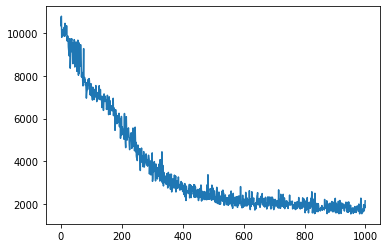

In [16]:
plt.plot(losses)

##### After performing inference, we construct the Bayes estimators of the means (the expected values of each factor in our variational approximation) and plot them in red on top of the original dataset. Note that we also have we removed any clusters that have less than a certain weight assigned to them according to our learned variational distributions, and then re-normalize the weights so that they sum to one:

In [18]:
def truncate(alpha, centers, weights):
    threshold = alpha ** -1 / 100
    print(threshold)
    true_centers = centers[weights > threshold]
    true_weights = weights[weights > threshold] / torch.sum(weights[weights > threshold])
    return true_centers, true_weights

In [21]:
torch.mean(pyro.param('phi').detach(), dim=0)

tensor([0.2743, 0.0542, 0.1491, 0.0822, 0.2168, 0.2235])

In [22]:
Bayes_Centers_01, Bayess_Weights_01 = truncate(alpha, pyro.param('tau').detach(), 
        torch.mean(pyro.param('phi').detach(), dim=0))

0.1


In [30]:
Bayes_Centers_02, Bayess_Weights_02 = truncate(alpha, pyro.param('tau').detach(), 
        torch.mean(pyro.param('phi').detach(), dim=0))

0.006666666666666666


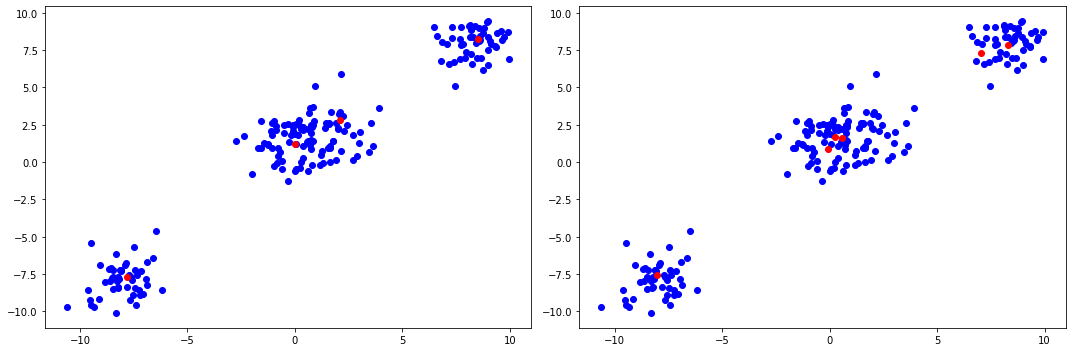

In [32]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(data[:, 0], data[:, 1], color="blue")
plt.scatter(Bayes_Centers_01[:, 0], Bayes_Centers_01[:, 1], color="red")

plt.subplot(1, 2, 2)
plt.scatter(data[:, 0], data[:, 1], color="blue")
plt.scatter(Bayes_Centers_02[:, 0], Bayes_Centers_02[:, 1], color="red")
plt.tight_layout()
plt.show()

The plots above demonstrate the effects of the scaling hyperparameter . A greater  yields a more heavy-tailed distribution of the weights, whereas smaller  will place more mass on fewer clusters. In particular, the middle cluster looks like it could be generated a single Gaussian (although in fact it was generated by two distinct Gaussians), and thus the setting of  allows the practitioner to further encode their prior beliefs about how many clusters the data contains.

### [Dirichlet Mixture Model for Long Term Solar Observations](http://pyro.ai/examples/dirichlet_process_mixture.html#Dirichlet-Mixture-Model-for-Long-Term-Solar-Observations)

#### As mentioned earlier, the Dirichlet process mixture model truly shines when exploring a dataset whose latent geometric structure is completely unknown. To demonstrate this, we fit a DPMM on sunspot count data taken over the past 300 years (provided by the Royal Observatory of Belgium):